<a href="https://colab.research.google.com/github/kiyong21c/Must_Have_Kaggle/blob/main/20220929_Bike_Sharing_Demand_Subplots_GridSpec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 자전거 대여 수요 예측
 - 날짜, 계절, 근무일 여부, 날씨, 온도, 풍속 데이터 활용 → 자전거 대여 수량 예측
 - 문제유형 : 회귀
 - 평가지표 : RMSE
 - 사용모델 : 랜덤 포레스트 회귀

In [31]:
import numpy as np
import pandas as pd

data_path = '/content/drive/MyDrive/Colab Notebooks/kaggle/input/bike-sharing-demand/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

In [32]:
train.shape, test.shape # 피처(특징) 개수에서 차이가 남

((10886, 12), (6493, 9))

In [33]:
# 길이가 다른 리스트 비교 : set() 활용
set(train.columns) - set(test.columns) # 'count'는 종속변수(target)

{'casual', 'count', 'registered'}

 - 모델 훈련시에도 'casual', 'registered' 제외 해야함

In [34]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


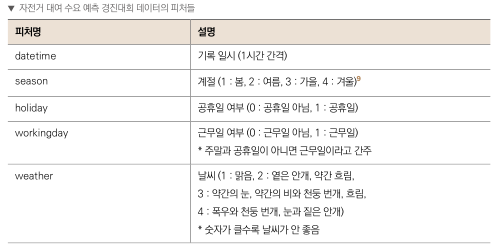

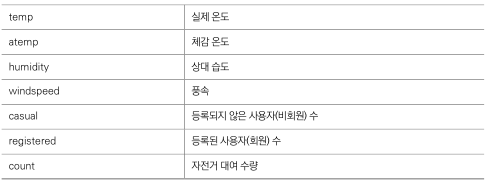

In [51]:
# 각 피처별 고유값이 몇개나 있는지 확인

dict = {}
for col in train.columns:
    if train[col].nunique() < 30:   # 고유값이 너무 많으면 범주형데이터라고 보기 어려움
        dict[col] = train[col].unique()
    else:
        pass
dict

{'season': array(['Spring', 'Summer', 'Fall', 'Winter'], dtype=object),
 'holiday': array([0, 1]),
 'workingday': array([0, 1]),
 'weather': array(['Clear', 'Mist, Few Coluds', 'Light Snow, Rain, Thunderstorm',
        'Heavy Rain, Thunderstorm, Snow, Fog'], dtype=object),
 'windspeed': array([ 0.    ,  6.0032, 16.9979, 19.0012, 19.9995, 12.998 , 15.0013,
         8.9981, 11.0014, 22.0028, 30.0026, 23.9994, 27.9993, 26.0027,
         7.0015, 32.9975, 36.9974, 31.0009, 35.0008, 39.0007, 43.9989,
        40.9973, 51.9987, 46.0022, 50.0021, 43.0006, 56.9969, 47.9988]),
 'year': array(['2011', '2012'], dtype=object),
 'month': array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
        '12'], dtype=object),
 'day': array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
        '12', '13', '14', '15', '16', '17', '18', '19'], dtype=object),
 'hour': array(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
        '11', '12', '13', '14',

 - train, test데이터는 날짜를 기준으로 train:1-19일, test:20-30일로 나눠놓음

In [37]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


 - 'datetime' 피처는 1시간 간격의 데이터 구분 역할
 - 즉, 인덱스와 다를바가 없으므로 삭제
 - 삭제하기 전에 datetime피처에서 쓸만한 피처를 추출할 예정(시기에 따른 대여변화가 있을 수 있으므로)

In [38]:
# 겉보기엔 날짜/시간 이지만 object 타입(판다스의 문자열)
# object 타입이기때문에 문자열처럼 다룰수 있음
train['datetime'][100] # '2011-01-05 09:00:00'
train['datetime'][100].split() # ['2011-01-05', '09:00:00']
train['datetime'][100].split()[0] # '2011-01-05'
train['datetime'][100].split()[1] # '09:00:00'

'09:00:00'

In [39]:
train['datetime'][100].split()[0] # '2011-01-05'
train['datetime'][100].split()[0].split('-') # ['2011', '01', '05']
train['datetime'][100].split()[0].split('-')[0] # '2011' → 연도
train['datetime'][100].split()[0].split('-')[1] # '01' → 월
train['datetime'][100].split()[0].split('-')[2] # '05' → 일

'05'

In [40]:
train['datetime'][100].split()[1] # '09:00:00'
train['datetime'][100].split()[1].split(':') # ['09', '00', '00']
train['datetime'][100].split()[1].split(':')[0] # '09' → 시
train['datetime'][100].split()[1].split(':')[1] # '00' → 분
train['datetime'][100].split()[1].split(':')[2] # '00' → 초

'00'

In [41]:
# datetime에서 몇가지 파생피처를 생성 : DF/Series.apply()
train['date'] = train['datetime'].apply(lambda x: x.split()[0]) # 날짜 피처 생성

train['year'] = train['datetime'].apply(lambda x: x.split()[0].split('-')[0]) # 연도 피처 생성
train['month'] = train['datetime'].apply(lambda x: x.split()[0].split('-')[1]) # 월 피처 생성
train['day'] = train['datetime'].apply(lambda x: x.split()[0].split('-')[2]) # 일 피처 생성
train['hour'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[0]) # 시 피처 생성
train['minute'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[1]) # 분 피처 생성
train['second'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[2]) # 초 피처 생초

In [42]:
# 날짜(object 타입) → 날짜(datetime 타입) → 요일(int타입) → 요일(object 타입)

from datetime import datetime
import calendar

train['date'][100] # 2011-01-05 : str
datetime.strptime(train['date'][100], '%Y-%m-%d') # datetime.datetime(2011, 1, 5, 0, 0) : datetime.datetime
datetime.strptime(train['date'][100], '%Y-%m-%d').weekday() # 2 : int
calendar.day_name[2] # Wednesday : str

'Wednesday'

In [43]:
train['weekday'] = train['date'].apply(lambda x: calendar.day_name[datetime.strptime(x, '%Y-%m-%d').weekday()])

In [44]:
dict

{'season': array([1, 2, 3, 4]),
 'holiday': array([0, 1]),
 'workingday': array([0, 1]),
 'weather': array([1, 2, 3, 4])}

 - season과 weather 피처는 숫자로 표현되어 있음
 - 의미파악이 쉽도록 문자열로 변경 : map()

In [45]:
# DF/Series.map({변경전:변경후})
train['season'] = train['season'].map({1:'Spring',
                                        2:'Summer',
                                        3:'Fall',
                                        4:'Winter'}) 
train['weather'] = train['weather'].map({1:'Clear',
                                        2:'Mist, Few Coluds',
                                        3:'Light Snow, Rain, Thunderstorm',
                                        4:'Heavy Rain, Thunderstorm, Snow, Fog'}) 

In [46]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00,Saturday
1,2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00,Saturday
2,2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,00,00,Saturday
3,2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,00,00,Saturday
4,2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,00,00,Saturday


 - 세분화된 month피처 → 세달씩 묶어서 season피처로
 - 지나치게 세분화된 피처를 더 큰 분류로 묶으면 성능이 좋아지기도 함

  > 데이터를 지엽적으로 판단하기 보다는 큰 흐름을 보는것이 좋음

### 데이터 시각화

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

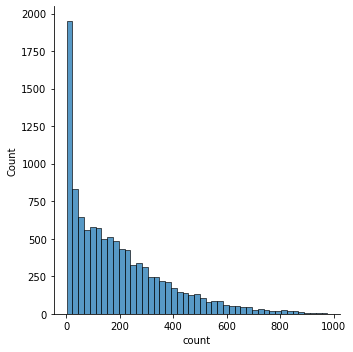

In [48]:
sns.displot(train['count']) # 타깃값인 count피처의 분포도

 - 타깃값인 count가 0근처에 몰려있음

  > 자전거대여횟수가 0인 날이 매우 많음

 - 분포가 편향되어 있어서 좋은 성능을 내기 어렵다 → 정규분포에 가깝게 만들어 주자

  > 로그변환 : 데이터가 왼쪽으로 편향시 주로 사용

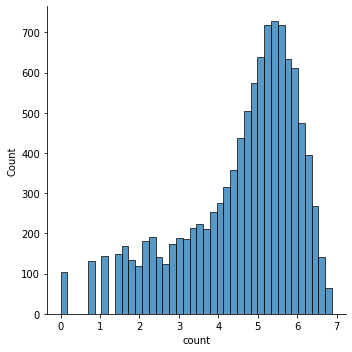

In [50]:
sns.displot(np.log(train['count']))

 - 로그변환 함에 따라 정규분포에 조금더 가까워짐
 - count예측이 아닌, log(count)를 예측하고
  
  > 마지막에 지수변환하여 count로 복원

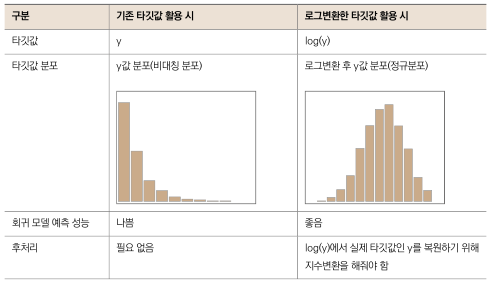

 - 범주형 피처('연도','월','일','시','분','초')에 따라 평균 대여수량이 어떻게 다른지 확인

  > 상관관계(추세확인 가능한지여부)를 통해 피처의 중요도 파악

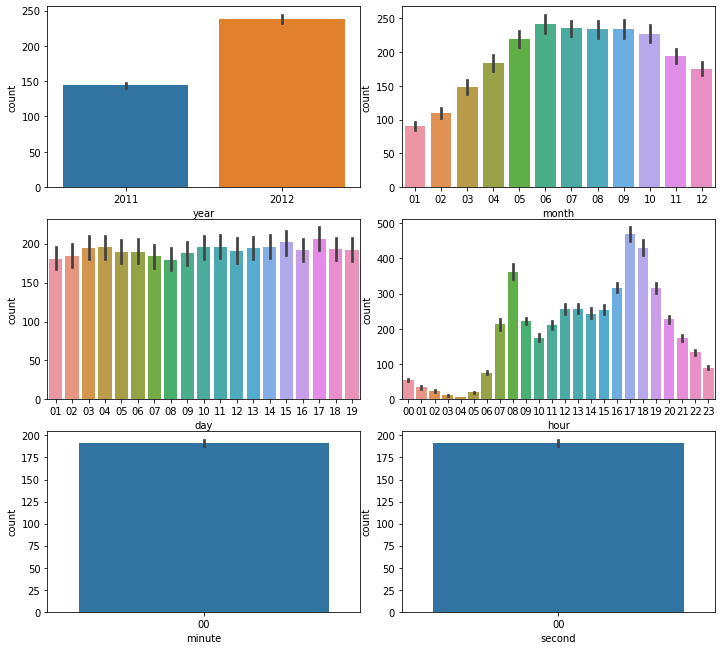

In [60]:
# subplots() 활용
fig, axes = plt.subplots(nrows=3, ncols=2) # 

fig.set_size_inches(10, 9) # 전체 Figure 사이즈
plt.tight_layout() # 서브플롯간의 간격을 확보(이름은 tight지만 의미는 다름)

for idx, x in enumerate(['year','month','day','hour','minute','second']):
    sns.barplot(x=x, y='count', data=train, ax=axes[idx // 2, idx % 2]) # ax 파라미터 : 2차원 배열

In [ ]:
# GridSpec 활용1
# ax = fig.add_subplot(gs) : GridSpec객체를 생성하여 figure에 축으로 밀어넣고 subplots()메서드 처럼 활용
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 9))
gs = GridSpec(nrows=3, ncols=2)

for idx, x in enumerate(['year','month','day','hour','minute','second']):
    ax = fig.add_subplot(gs[idx]) # GridSpec()활용하면 2차원 축을 1차원 처럼 활용가능, 축 객체생성
    sns.barplot(x=x, y='count', data=train, ax=ax) # 축객체에 plot

In [ ]:
# GridSpec 활용2
# ax = plt.subplot(gs[i]) : subplot()메서드 활용하여 함수형으로 코딩

fig = plt.figure(figsize=(10, 9))
gs = GridSpec(nrows=3, ncols=2)

for idx, x in enumerate(['year','month','day','hour','minute','second']):
    plt.subplot(gs[idx]) # 축을 GridSpec()에 따라 순차적으로 생성(축 객체 생성하지 않음)
    sns.barplot(x=x, y='count', data=train) # 순차적으로 plot(축을 지정하지 않음)

 - GridSpec()활용시 장점
  
  > 축을 별도로 지정하거나, 함수형 프로그래밍 방식으로 다양하게 사용가능

  > 여러개의 서브플롯 사용시에도 그리드스펙 객체를 1차원 형태로 편하게 사용가능

 - 범주형 피처('계절','날씨','공휴일','근무일')에 따라 평균 대여수량이 어떻게 다른지 확인

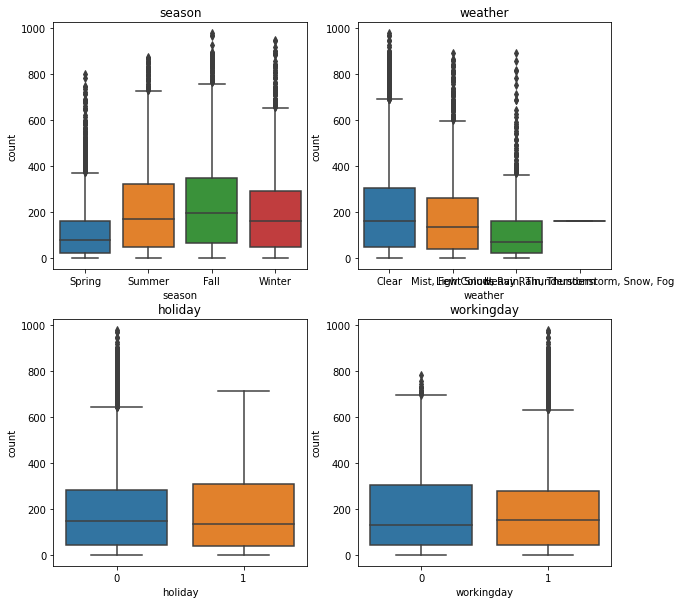

In [75]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(nrows=2, ncols=2)

for idx, x in enumerate(['season','weather','holiday','workingday']):
    # 방법1 : 축객체를 생성 → 축에다가 plot
    ax = fig.add_subplot(gs[idx])
    sns.boxplot(x=x, y='count', data=train, ax=ax)
    ax.set_title(f'{x}')
    # 방법2 : 축을 그림 → plot
    # plt.subplot(gs[idx])
    # sns.boxplot(x=x, y='count', data=train)

 - holiday : 0 : 공휴일 아님, 1 : 공휴일
 - workingday : 0 : 공휴일 또는 주말, 1 : 근무일
 - 두가지 의미는 거의 비슷

 - 근무일, 공휴일, 요일, 계절, 날씨에 따른 시간대별 평균 대여수량

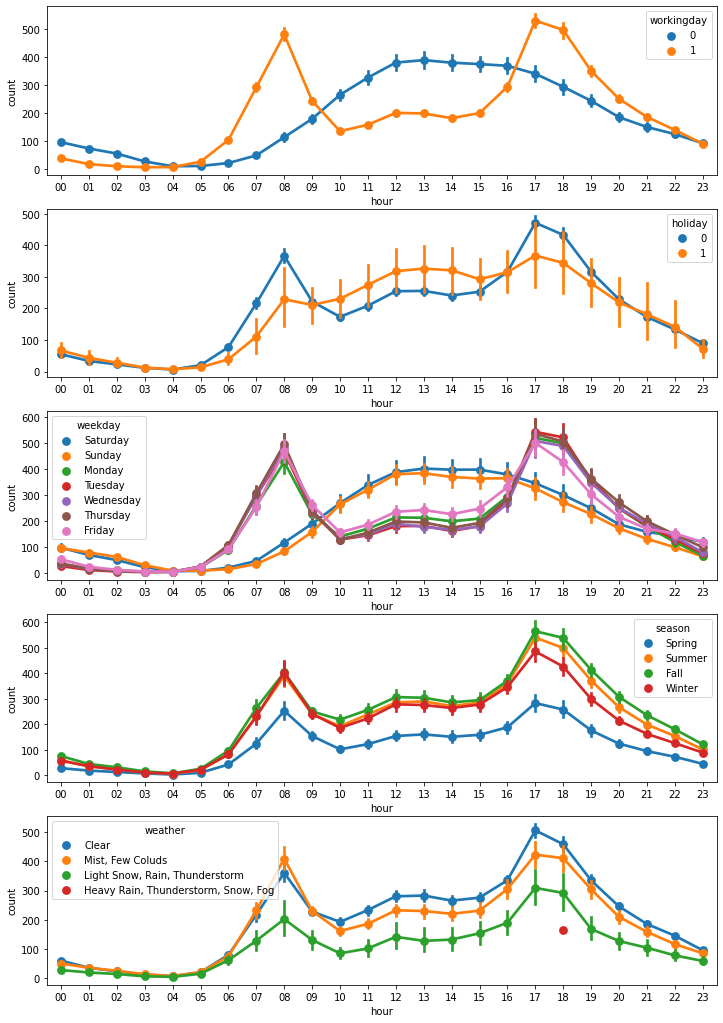

In [80]:
fig = plt.figure(figsize=(12, 18))
gs = GridSpec(nrows=5, ncols=1)

for idx, x in enumerate(['workingday','holiday','weekday','season','weather']):
    ax = fig.add_subplot(gs[idx])
    sns.pointplot(x='hour', y='count', data=train, hue=x, ax=ax)

 - 수치형 데이터(온도, 체감, 온도, 풍속, 습도)별 대여 수량을 '회귀선을 포함한 산점도 그래프'로 표현
  
  > 수치형 데이터간 상관관계를 파악하는데 사용

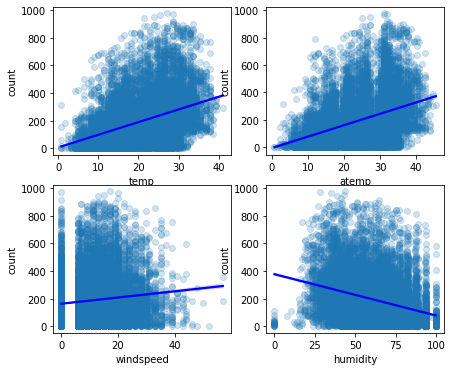

In [82]:
fig = plt.figure(figsize=(7, 6))
gs = GridSpec(nrows=2, ncols=2)

for idx, x in enumerate(['temp','atemp','windspeed','humidity']):
    ax = fig.add_subplot(gs[idx])
    # regplot : regression plot의 줄임말
    sns.regplot(x=x, y='count', data=train, ax=ax,
                  scatter_kws={'alpha':0.2},    # 산점도 그래프에 찍히는 점의 투명도
                  line_kws={'color':'blue'})    # 회귀선의 색상

 - windspeed - count의 상관관계 plot에서
 - 0에서의 데이터 값이 많은것은 실제로 풍속이 0이 아니라
 - 관측치가 없거나 오류로 인해 0으로 기록됬을 가능성이 높음

  > windspeed - count간의 상관관계 파악이 어려우므로 피처 삭제

 - 수치형 피처간의 상관관계 파악을 위해 히트맵 사용 : corr(), heatmap()

In [84]:
# DF.corr()
train[['temp','atemp','humidity','windspeed','count']].corr() # DataFrame내의 피처 간 상관계수를 계산해 반환

,temp,atemp,humidity,windspeed,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.394454,0.389784,-0.317371,0.101369,1.000000


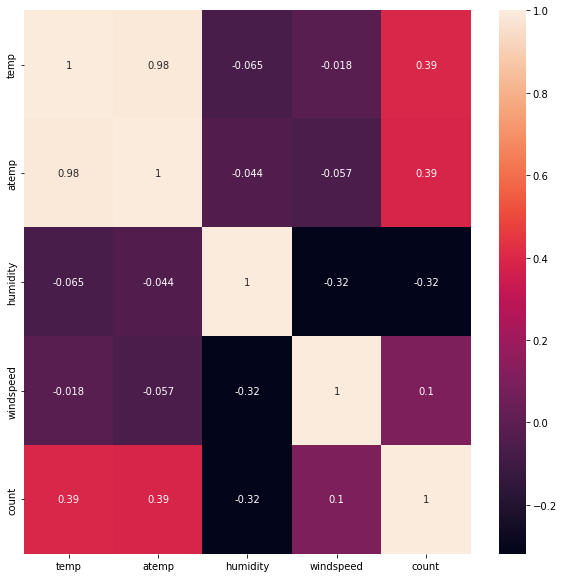

In [85]:
# 피처 간 상관관계 매트릭스
corrMat = train[['temp','atemp','humidity','windspeed','count']].corr()
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
sns.heatmap(corrMat, annot=True) # annot : 상관관계 숫자 표시

 - (-)음수이면, 음의 상관관계